In [1]:
import nltk
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.utils
import torch.utils.data
from torch.optim import lr_scheduler

import re
import random

from wordExtractor import wordExtractor
from dictConfig import replaceDict

# 小工具

In [2]:
import time
def log(*k, **kw):
    timeStamp = time.strftime('[%y-%m-%d %H:%M:%S] ', time.localtime())
    print(timeStamp, end='')
    print(*k, **kw)
def debug(*k, stop=False, **kw):
    print('[DEBUG] ', end='')
    print(*k, **kw)
    if stop:
        raise SystemExit

In [3]:
def getPara(module, useString=True):
    para = sum([x.nelement() for x in module.parameters()])
    if not useString:
        return para
    elif para >= 2**20:
        return '{:.2f}M'.format(para / 2**20)
    elif para >= 2**10:
        return '{:.2f}K'.format(para / 2**10)
    else:
        return str(para)
def savemodel(name, model):
    torch.save(model.state_dict(), name + '.pt')
def loadmodel(name, model):
    model.load_state_dict(torch.load(name + '.pt'))

使用<>包夹表示特殊词，不作处理

# 文本处理

In [4]:
emojiDict = {
    ':)': '<smile>',
    ':D': '<smile>',
    ':.(': '<cry>',
    '-.-': '<emoji1>',
    '-__-': '<emoji2>',
    '>.>': '<emoji3>',
    'O.o': '<emoji4>',
    ':??': '<emoji4>',
    ':-/': '<emoji4>',
    'Lol': '<emoji4>',
}
chineseDict = {
    '\u2019': "'",
    '\u002c': ',',
}

In [5]:
extractor = wordExtractor()
extractor.addDict(replaceDict)

# stemmer = nltk.stem.LancasterStemmer()
# lemmatizer = nltk.stem.WordNetLemmatizer()

stopSet = set(nltk.corpus.stopwords.words('english'))

In [6]:
def seperateSpecialElement(wordsTargetList):
    i = 0
    while i != len(wordsTargetList):
        word, isTarget = wordsTargetList[i]
        s = re.search('<\w*>', word)
        if s != None:
            wordsTargetList.pop(i)
            one = word[:s.start()]
            two = word[s.start():s.end()]
            three = word[s.end():]
            if len(one) != 0:
                wordsTargetList.insert(i, (one, isTarget))
                i += 1
            wordsTargetList.insert(i, (two, isTarget))
            i += 1
            if len(three) != 0:
                wordsTargetList.insert(i, (three, isTarget))
        else:
            i += 1
    return wordsTargetList

In [7]:
def removeFullStop(wordsTargetList):
    wordsTargetPureList = []
    for word, isTarget in wordsTargetList:
        newList = [(newW, isTarget) for newW in re.split('[.,]', word) if len(newW) != 0]
        wordsTargetPureList.extend(newList)
    return wordsTargetPureList

In [8]:
def lemmatize(word, pos):
    if pos == 'NN':
        return lemmatizer.lemmatize(word, pos='n')
    if pos == 'VB':
        return lemmatizer.lemmatize(word, pos='v')
    if pos == 'JJ':
        return lemmatizer.lemmatize(word, pos='a')
    if pos == 'R':
        return lemmatizer.lemmatize(word, pos='r')
    else:
        return word

In [9]:
# 转小写
# -> 展开缩写  
# -> 空格分割  
# -> 标记@网名 -> 标记#topic  
# -> 标记网址  
# -> 表情包:) :D :.(  
# -> 标记target  
# -> 删除".,"，断句  
# ? -> 标记无用词  
# ? -> 删除  
# x -> 转词根  
# x -> 词性标准 -> 词性还原  
# x -> 停词

# 返回处理后的文本和target
def processSentence(text, target):
    # 转小写
    lowerText = text.lower()
    # 移除中文字符
    for c in chineseDict:
        lowerText = lowerText.replace(c, chineseDict[c])
    # 展开缩写
    # expendText = extractor.expand_contractions(lowerText)

    # 空格分割
    # wordsList = expendText.split()
    wordsList = lowerText.split()
    # 标记@网名
    wordsList = [re.sub(r'@[\w_]*', '<user>', word) for word in wordsList]
    # 标记#topic
    wordsList = [re.sub(r'#\w*', '<topic>', word) for word in wordsList]
    # 标记网址
    wordsList = [re.sub(r'http(s)?://.*', '<web>', word) for word in wordsList]
    # 标记省略号
    wordsList = [re.sub(r'\.{3,}', '<ellipsis>', word) for word in wordsList]
    # 标记感叹号
    wordsList = [re.sub(r'!', '<exclamation>', word) for word in wordsList]
    # 标记问号
    wordsList = [re.sub(r'\?', '<question>', word) for word in wordsList]
    # 标记数字
    wordsList = [re.sub(r'\d+\.?\d*', '<number>', word) for word in wordsList]
    # 标记表情包
    for emoji in emojiDict:
        wordsList = [word.replace(emoji.lower(), emojiDict[emoji]) for word in wordsList]

    # 标记target
    wordsTargetList = [(word, target[0] <= i <= target[1]) for i, word in enumerate(wordsList)]
    # 展开缩写
    wordsTargetList_ = []
    for word, isTarget in wordsTargetList:
        newWord = extractor.expand_contractions(word)
        if newWord == word:
            wordsTargetList_.append((word, isTarget))
        else:
            for w in newWord.split():
                wordsTargetList_.append((w, isTarget))
    wordsTargetList = wordsTargetList_
    # 分离特殊符号<***>
    wordsTargetList = seperateSpecialElement(wordsTargetList)
    # 删除".,"，断句
    wordsTargetList = removeFullStop(wordsTargetList)

    # -> 词性标准 -> 词性还原 
    # pureText, isTargets = zip(*wordsTargetList)
    # _, pos_tags = zip(*nltk.pos_tag(pureText))

    # oriText = [lemmatize(word, pos=pos) for word, pos in zip(pureText, pos_tags)]
    # oriText = [stemmer.stem(word) for word in oriText]

    # wordsTargetList = list(zip(oriText, isTargets))

    # 去除停用词
    # wordsTargetList = [(word, isTarget) for word, isTarget in wordsTargetList if word not in stopSet]
    
    # 加上结束符
    wordsTargetList.append(('<EOS>', False))
    finText, isTargets = zip(*wordsTargetList)
    # 恢复target
    beg = -1
    end = -1
    for i, isTarget in enumerate(isTargets):
        if isTarget and beg == -1:
            beg = i
        if not isTarget and beg != -1:
            end = i - 1
            break
            
    return finText, (beg, end)

## 测试

In [10]:
texts = [
    "@Mrf Don't hesitate  to ask questions. Be positive,Keep positive. Emm:D:DHMm.... they'll be selected",
    'Yes\u002c I intend to go everyweek\u002c but of course that\u2019s not confirmed.Hope you get well soon.May you be free from physical sufferin.',
    'Oh... I c i c... Haha\u002c xin ask u to take away food 4 her\u002c pau or smethg... Gee\u002c can help me buy packet milo? Thanx sweety...',
    '#Vote4UrDAYUMSelf Comedy Show w/ @Ali_Speaks TOMORROW @ the Houston Improv, 7:30 PM. FREE SHOW! Get... http://t.co/by9COiwf',
    "Gas by my house hit $3.39!!!! OK.I'm going to Chapel Hill on Sat. :)",
    "`` Thud '' means it is just a boring wordcount post .",
]
for text in texts:
    print(text)
    print(processSentence(text, (3, 5)))

@Mrf Don't hesitate  to ask questions. Be positive,Keep positive. Emm:D:DHMm.... they'll be selected
(('<user>', 'do', 'not', 'hesitate', 'to', 'ask', 'questions', 'be', 'positive', 'keep', 'positive', 'emm', '<smile>', '<smile>', 'hmm', '<ellipsis>', 'they', 'will', 'be', 'selected', '<EOS>'), (4, 6))
Yes, I intend to go everyweek, but of course that’s not confirmed.Hope you get well soon.May you be free from physical sufferin.
(('yes', 'i', 'intend', 'to', 'go', 'everyweek', 'but', 'of', 'course', 'that', 'is', 'not', 'confirmed', 'hope', 'you', 'get', 'well', 'soon', 'may', 'you', 'be', 'free', 'from', 'physical', 'sufferin', '<EOS>'), (3, 5))
Oh... I c i c... Haha, xin ask u to take away food 4 her, pau or smethg... Gee, can help me buy packet milo? Thanx sweety...
(('oh', '<ellipsis>', 'i', 'c', 'i', 'c', '<ellipsis>', 'hah', 'xin', 'ask', 'uou', 'to', 'take', 'away', 'food', '<number>', 'her', 'pau', 'or', 'smethg', '<ellipsis>', 'gee', 'can', 'help', 'me', 'buy', 'packet', 'milo

词性还原
https://blog.csdn.net/qq_16234613/article/details/79430381

# 生成字典

In [11]:
tableFiles = [
    'target-sentiment-analysis/train.tsv',
    'target-sentiment-analysis/test.tsv'
]

threshold = 4

log('正在加载字典')
fdist = nltk.probability.FreqDist()
for tableFile in tableFiles:
    table = pd.read_csv(tableFile, sep='\t', 
                names=['ID1','ID2','index1','index2', 'polarity','text'])
    for text in table['text']:
        newText, _ = processSentence(text, target=(0,0))
        fdist.update(newText)

index2word = [word for word, freq in fdist.most_common() if freq > threshold]
index2word.append('<unknown>')

filte = len(fdist)-len(index2word)
filteFreq = sum([freq for _, freq in fdist.most_common()[len(index2word):]])
sumFreq = sum([freq for _, freq in fdist.most_common()])

print('已过滤低频词（freq<{}）个数：{} （{:.2f}%）词频占比：{:.2f}%'
          .format(threshold, filte, 100 * filte / len(fdist), 100 * filteFreq / sumFreq)
     )

word2index = { word: i for i, word in enumerate(index2word) }

log('加载字典完成')

[19-07-13 09:37:47] 正在加载字典
已过滤低频词（freq<4）个数：13832 （72.51%）词频占比：7.04%
[19-07-13 09:38:02] 加载字典完成


In [12]:
def sentence2Tensor(sentence):
    change = lambda word: word if word in word2index else '<unknown>'
    return torch.tensor([word2index[change(word)] for word in sentence])
def tensor2Sentence(tensor, join=True):
    if join:
        return ' '.join([index2word[i] for i in tensor])
    else:
        return [index2word[i] for i in tensor]

# 定义数据集

In [13]:
class corpusData():
    def __init__(self, table):
        self.table = table
        self.corpus = self.loadCorpus(table)
        self.processedCorpus = self.processe(self.corpus)
    def processe(self, corpus):
        processedCorpus = []
        popIndex = []
        for i, (text, target, polarity) in enumerate(corpus):
            newText, newTarget = processSentence(text, target)
            
            # 部分测试数据下标越界，导致target无法识别，此处去掉
            if newTarget == (-1, -1):
                popIndex.append(i)
            else:
                processedCorpus.append((newText, newTarget, polarity))
        for i in popIndex[::-1]:
            corpus.pop(i)
        return processedCorpus
    def loadCorpus(self, table):
        corpus = []

        polarityClass = {
            'positive': 0,
            'neutral': 1,
            'negative': 2,
            'unknwn': 3
        }

        for _, line in table.iterrows():
            target = (line['index1'], line['index2'])
            polarity = polarityClass[line['polarity']]
            text = line['text']
            corpus.append((text, target, polarity))
        return corpus
    def getRawText(self, index):
        return self.corpus[index][0]
    def getProcessedText(self, index, join=True):
        if join:
            return ' '.join(self.processedCorpus[index][0])
        else:
            return self.processedCorpus[index][0]
    def splitTrainAndValidationSet(self, trainFrac=0.9, random_state=10):
        table = self.table.sample(frac=1, random_state=random_state)
    
        assert 0 < trainFrac < 1
        TRAIN_SIZE = int(trainFrac*len(self))
        
        tableTrain = table[:TRAIN_SIZE]
        tableValdate = table[TRAIN_SIZE:]

        trainSet = corpusData(table=tableTrain)
        valSet = corpusData(table=tableValdate)
        
        return trainSet, valSet
    def __getitem__(self, index):
        text = self.getProcessedText(index, join=False)
        _, target, polarity = self.processedCorpus[index]
        return sentence2Tensor(text), len(text), target, polarity
    def __len__(self):
        return len(self.processedCorpus)

In [14]:
def collate_fn_corpus(batch):
    with torch.no_grad():
        texts, lens, targets, polaritys = zip(*batch)
        maxlen = max(lens)
        batchTexts = [torch.nn.functional.pad(text, pad=(0, maxlen-len(text))) for text in texts]
        batchTexts = torch.stack(batchTexts)
    return batchTexts, torch.tensor(lens), torch.tensor(targets), torch.tensor(polaritys)

# 测试集、验证集的加载

In [ ]:
log('开始加载')
table = pd.read_csv('target-sentiment-analysis/train.tsv', sep='\t', 
            names=['ID1','ID2','index1','index2', 'polarity','text'])

dataset = corpusData(table=table)
trainSet, valSet = dataset.splitTrainAndValidationSet(trainFrac=0.9, random_state=10)

testTable = pd.read_csv('target-sentiment-analysis/test.tsv', sep='\t', 
            names=['ID1','ID2','index1','index2', 'polarity','text'])

testset = corpusData(table=testTable)

trainloader = torch.utils.data.DataLoader(trainSet, batch_size=5, collate_fn=collate_fn_corpus, shuffle=True)
validateloader = torch.utils.data.DataLoader(valSet, batch_size=5, collate_fn=collate_fn_corpus, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, collate_fn=collate_fn_corpus, shuffle=False)
log('加载完成')

In [478]:
next(iter(valloader))

(tensor([[    3,    86,    12,    41,    77,     1,   132,   152,   662,    64,
              1,     2,  2650,    39,    18,  4878,   381,    70,     3,   511,
             19,    89,    18,     1,    35,    73,   148,  1520,     0],
         [    5,   162,  2137,     2,    68,     3,    35,   166,     4,  2638,
           1666,   310,     1,    48,     1,   101,     7,  4699,   470,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0],
         [    1,  2751,    14,  1790,   203,    69, 14852,     4,   133,     2,
              1,    33,    58,     1,   189,  2904,   146,    92,   480,    32,
            206,    19,    37,   682,     4,    31,     0,     0,     0],
         [ 4836,  1117, 13538,   261,    15,     5, 13539, 13540,  2209,   520,
             22,     2,    65,   517, 13541,  3111,  3112,     9,  4189,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  496,   357,   160,   597,    10,   301, 14832,    25

In [477]:
for texts, lens, targets, polarity in valloader:
    print(texts.shape, lens.shape, targets.shape, polarity.shape)

torch.Size([5, 29]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 37]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 29]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 42]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 29]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 24]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 27]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 35]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 28]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 33]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 26]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 27]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 26]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.Size([5, 29]) torch.Size([5]) torch.Size([5, 2]) torch.Size([5])
torch.

# 训练函数

In [15]:
def train(model, loss_func, optimizer, trainloader, device, weight_decay):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    model.train()
    
    trainAccuracy = 0
    trainLoss = 0
    total = 0
    
    for i, (*material, targets) in enumerate(trainloader):
        if isinstance(material, torch.Tensor):
            material = material.to(device)
        else:
            material = [m.to(device) for m in material]
        
        targets = targets.to(device)

        # forward
        outputs = model(*material)
        
        loss = loss_func(outputs, targets)
        trainLoss += loss.item()

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # AdamW - https://zhuanlan.zhihu.com/p/38945390
        for group in optimizer.param_groups:
            for param in group['params']:
                param.data = param.data.add(-weight_decay * group['lr'], param.data)

        # return the maximum value of each row of the input tensor in the 
        # given dimension dim, the second return vale is the index location
        # of each maxium value found(argmax)
        _, predicted = torch.max(outputs.data, dim=1)
        trainAccuracy += (predicted == targets).sum().item()
        
        total += len(targets)
    trainAccuracy /= total
    trainLoss /= total
    return trainLoss, trainAccuracy

In [41]:
def validate(model, loss_func, validateloader, device):
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        # =============================================================
        valAccuracy = 0
        valLoss = 0
        total = 0
        
        for i, (*material, targets) in enumerate(trainloader):
            if isinstance(material, torch.Tensor):
                material = material.to(device)
            else:
                material = [m.to(device) for m in material]

            targets = targets.to(device)
            
            outputs = model(*material)
            
            loss = loss_func(outputs, targets)
            valLoss += loss.item()
            
            # return the maximum value of each row of the input tensor in the 
            # given dimension dim, the second return vale is the index location
            # of each maxium value found(argmax)
            _, predicted = torch.max(outputs.data, dim=1)
            valAccuracy += (predicted == targets).sum().item()
            
            total += len(targets)
        valAccuracy /= total
        valLoss /= total
    return valLoss, valAccuracy

In [175]:
def test(model, testloader, classname=None, name='default'):
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        result = []
        test_cnt = 0
        for i, (*material, targets) in enumerate(testloader):
            if isinstance(material, torch.Tensor):
                material = material.to(device)
            else:
                material = [m.to(device) for m in material]

            targets = targets.to(device)

            outputs = model(*material)

            _, predicted = torch.max(outputs.data, dim=1)

            result.extend(predicted)
            test_cnt += len(targets)

    if classname != None:
        result = [classname[i] for i in result]

    log('共预测{}个数据'.format(test_cnt))
    df_predict = pd.DataFrame({'id': list(range(1, len(result)+1)), 'polarity': result})
    df_predict.to_csv('{}.csv'.format(name), index=False)
    log('预测完成')

In [17]:
def showCurve(list_trainLoss, list_trainAccuracy, list_valLoss, list_valAccuracy):
    xAxis = list(range(len(list_trainLoss)))
    fig, axs = plt.subplots(1, 2)

    axs[0].plot(xAxis, list_trainLoss, label='train')
    axs[0].plot(xAxis, list_valLoss, label='validation')
    axs[0].set_title('Loss')

    axs[1].plot(xAxis, list_trainAccuracy, label='train')
    axs[1].plot(xAxis, list_valAccuracy, label='validation')
    axs[1].set_title('Accuracy')

    for ax in axs:
        ax.axis()
        ax.set_xlabel('epoch')
        ax.set_ylabel('{}'.format(ax.get_title()))
        ax.legend()
    fig.set_size_inches((8, 4))
    plt.subplots_adjust(wspace=0.3)
    plt.show()

# 训练

In [ ]:
device = 'cpu'

model = ...
model = model.to(device)

loss_func = torch.nn.CrossEntropyLoss()
lr = 0.01
num_epoches = 5
weight_decay=5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

results_train = []
results_val = []

log('开始训练')
for epoch in range(num_epoches):
    res_train = train(model, loss_func, optimizer, trainloader, device, weight_decay=weight_decay)
    res_val = validate(model, loss_func, validateloader, device)
    
    (trainLoss, trainAccuracy) = res_train
    (valLoss, valAccuracy) = res_val
    results_train.append(res_train)
    results_val.append(res_val)
    log('[{:2d}/{}] Loss (Train: {:.6f}, Validation: {:.6f})     Accuracy (Train: {:.4f}, Validation: {:.4f})'
              .format(epoch+1, num_epoches, trainLoss, valLoss, trainAccuracy, valAccuracy))
    
    scheduler.step()

showCurve(*zip(*results_train), *zip(*results_val))

# word bedding

In [36]:
class embeddingNetwork(torch.nn.Module):
    def __init__(self, embedding_dim, num_classes, p=0.5):
        super(embeddingNetwork, self).__init__()
        
        self.p = p
        self.embedding = torch.nn.Embedding(num_embeddings=len(index2word), embedding_dim=embedding_dim)
        
        self.relu = torch.nn.ReLU()
        
        self.fc = torch.nn.Linear(embedding_dim, num_classes)
        self.softmax = torch.nn.Softmax(dim=1)
        

    def forward(self, texts, lens, targets):
        """
        input: N * 3 * image_size * image_size
        output: N * num_classes
        """
        out = self.embedding(texts)
        
        # 给embeding完的work在target周围指数加权
        with torch.no_grad():
            weights = torch.zeros(*out.shape[:-1], dtype=torch.float)
            for weight, target, textlen in zip(weights, targets, lens):
                textlen = textlen.item()
                weight[:target[0]] = torch.tensor([self.p**i for i in range(target[0], 0, -1)])
                weight[target[0]:target[1]+1] = 1
                weight[target[1]+1:textlen] = torch.tensor([self.p**i for i in range(1, textlen-target[1])])
            weights.unsqueeze_(-1)
        
        # 对embeding的结果加权，继续传播
        out = (weights * out).sum(dim=[1])
        out = self.relu(out)
        out = self.fc(out)
        out = self.softmax(out)
        
        return out


[19-07-12 23:34:19] 开始训练
[19-07-12 23:34:45] [ 1/5] Loss (Train: 0.159831, Validation: 0.141543)     Accuracy (Train: 0.7440, Validation: 0.8413)
[19-07-12 23:35:20] [ 2/5] Loss (Train: 0.141029, Validation: 0.136285)     Accuracy (Train: 0.8443, Validation: 0.8687)
[19-07-12 23:35:57] [ 3/5] Loss (Train: 0.136739, Validation: 0.135532)     Accuracy (Train: 0.8658, Validation: 0.8727)
[19-07-12 23:36:39] [ 4/5] Loss (Train: 0.134046, Validation: 0.132375)     Accuracy (Train: 0.8800, Validation: 0.8891)
[19-07-12 23:37:21] [ 5/5] Loss (Train: 0.132591, Validation: 0.130247)     Accuracy (Train: 0.8875, Validation: 0.8997)



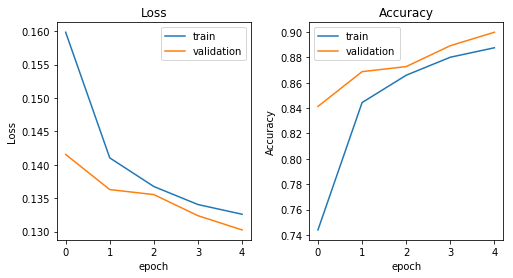

In [47]:
device = 'cpu'

embedding_dim = 100

model = embeddingNetwork(embedding_dim=embedding_dim, num_classes=3)
model = model.to(device)

loss_func = torch.nn.CrossEntropyLoss()
lr = 0.01
num_epoches = 5
weight_decay=5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

results_train = []
results_val = []

log('开始训练')
for epoch in range(num_epoches):
    res_train = train(model, loss_func, optimizer, trainloader, device, weight_decay=weight_decay)
    res_val = validate(model, loss_func, validateloader, device)
    
    (trainLoss, trainAccuracy) = res_train
    (valLoss, valAccuracy) = res_val
    results_train.append(res_train)
    results_val.append(res_val)
    log('[{:2d}/{}] Loss (Train: {:.6f}, Validation: {:.6f})     Accuracy (Train: {:.4f}, Validation: {:.4f})'
              .format(epoch+1, num_epoches, trainLoss, valLoss, trainAccuracy, valAccuracy))
    
    scheduler.step()

showCurve(*zip(*results_train), *zip(*results_val))

In [176]:
test(model, testloader, classname=['positive', 'neutral', 'negative'], name='BW')

[19-07-13 02:20:33] 共预测5267个数据
[19-07-13 02:20:33] 预测完成


In [48]:
getPara(model)

'512.41K'